In [38]:
import os
import sys
#from utils import get_value
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
from datetime import datetime
import csv
import numpy as np

# Add the path of DCGM Bindings
sys.path.append("/usr/local/dcgm/bindings/python3")
from utils import DCGM_AGENT

In [17]:
WORKLOAD_SMALL = [(1 << i) for i in range(10,20)]
WORKLOAD_HEAVY = [(1 << i) for i in range(20,32)]
PATH_TO_KERNELS = "../examples/cuda_samples/bin/x86_64/release"
KERNELS = ["vectorAdd", "MatAdd"]
NUM_THREADS_PER_BLOCK = [(1 << i) for i in range(0,11)]

In [25]:
df = pd.DataFrame()
for k in KERNELS:
    print(f"KERNEL: {k}")
    for w in WORKLOAD_SMALL:
        for t in NUM_THREADS_PER_BLOCK:
            if (k == "MatAdd") & ((t > 32) | (w > (1 << 14))):
                continue
            ret = os.popen(f"ncu -c 1 --set full --csv {PATH_TO_KERNELS}/{k} -nN={w} -nT={t}").read()
            if "PASSED" in ret:
                for idx,l in enumerate(ret.split('\n')):
                    if "==PROF== Disconnected" in l:
                        break
                if df.empty:
                    df = pd.read_csv(StringIO('\n'.join(ret.split('\n')[idx+1:-1])), sep=',', header=0)
                else:
                    df = pd.concat([df, pd.read_csv(StringIO('\n'.join(ret.split('\n')[idx+1:-1])), sep=',', header=0)])
            else:
                print(f"NOT PASSED, conf: t = {t}, w = {w}")

                    
date = datetime.now().strftime("%Y%m%d%H%M")
df.to_csv(f"out_{date}.csv", index=False)
#df = df.iloc[0:0]



KERNEL: vectorAdd
KERNEL: MatAdd


In [6]:
date = datetime.now().strftime("%Y%m%d%H%M")
df.to_csv(f"out2_{date}.csv", index=False)

In [27]:
#df = pd.read_csv("out_202402102005.csv", sep=',', header=0)

In [26]:

def get_value(k_key: str, w_key : int, t_key : int, m_key: str, df):
    numBlock = int(w_key / t_key)
    if k_key == "vectorAdd":
        mask = (df['Kernel Name'].str.contains(k_key)) & (df['Block Size'] == f"({t_key}, 1, 1)") & (df['Metric Name'] == m_key) & (df['Grid Size'] == f"({numBlock}, 1, 1)")
    elif k_key == "MatAdd":
        mask = (df['Kernel Name'].str.contains(k_key)) & (df['Block Size'] == f"({t_key}, {t_key}, 1)") & (df['Metric Name'] == m_key) & (df['Grid Size'] == f"({numBlock}, {numBlock}, 1)")

    return df.loc[mask,'Metric Value'].values[0]


# vectorAdd Analysis
## Compute Workload Analysis

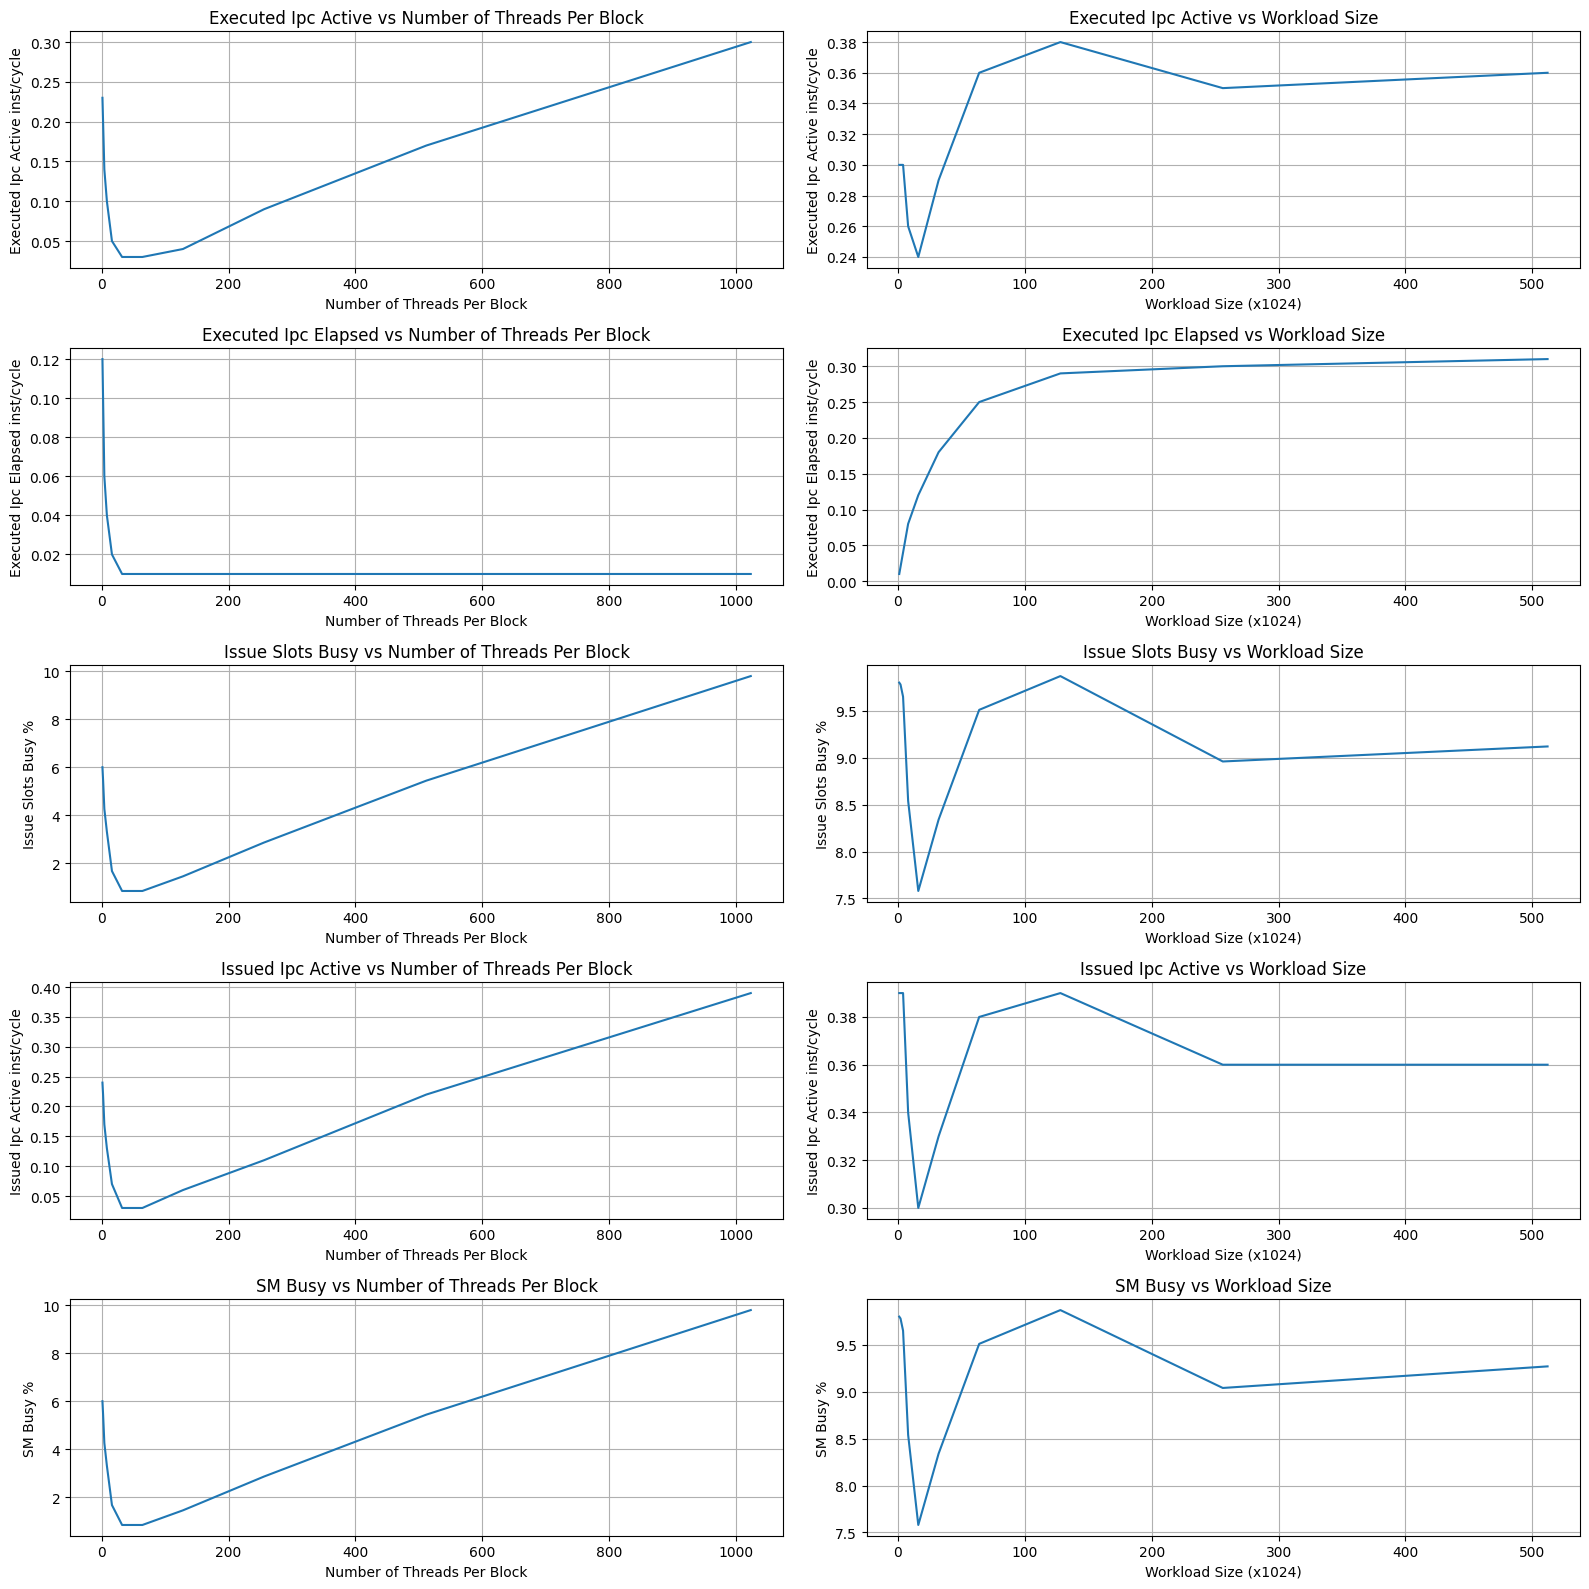

In [31]:
# Waves Per SM
metrics = ['Executed Ipc Active', 'Executed Ipc Elapsed', 'Issue Slots Busy', 'Issued Ipc Active', 'SM Busy']
metrics_u = ['inst/cycle','inst/cycle','%','inst/cycle','%']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(5, 2, figsize=(16, 16),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

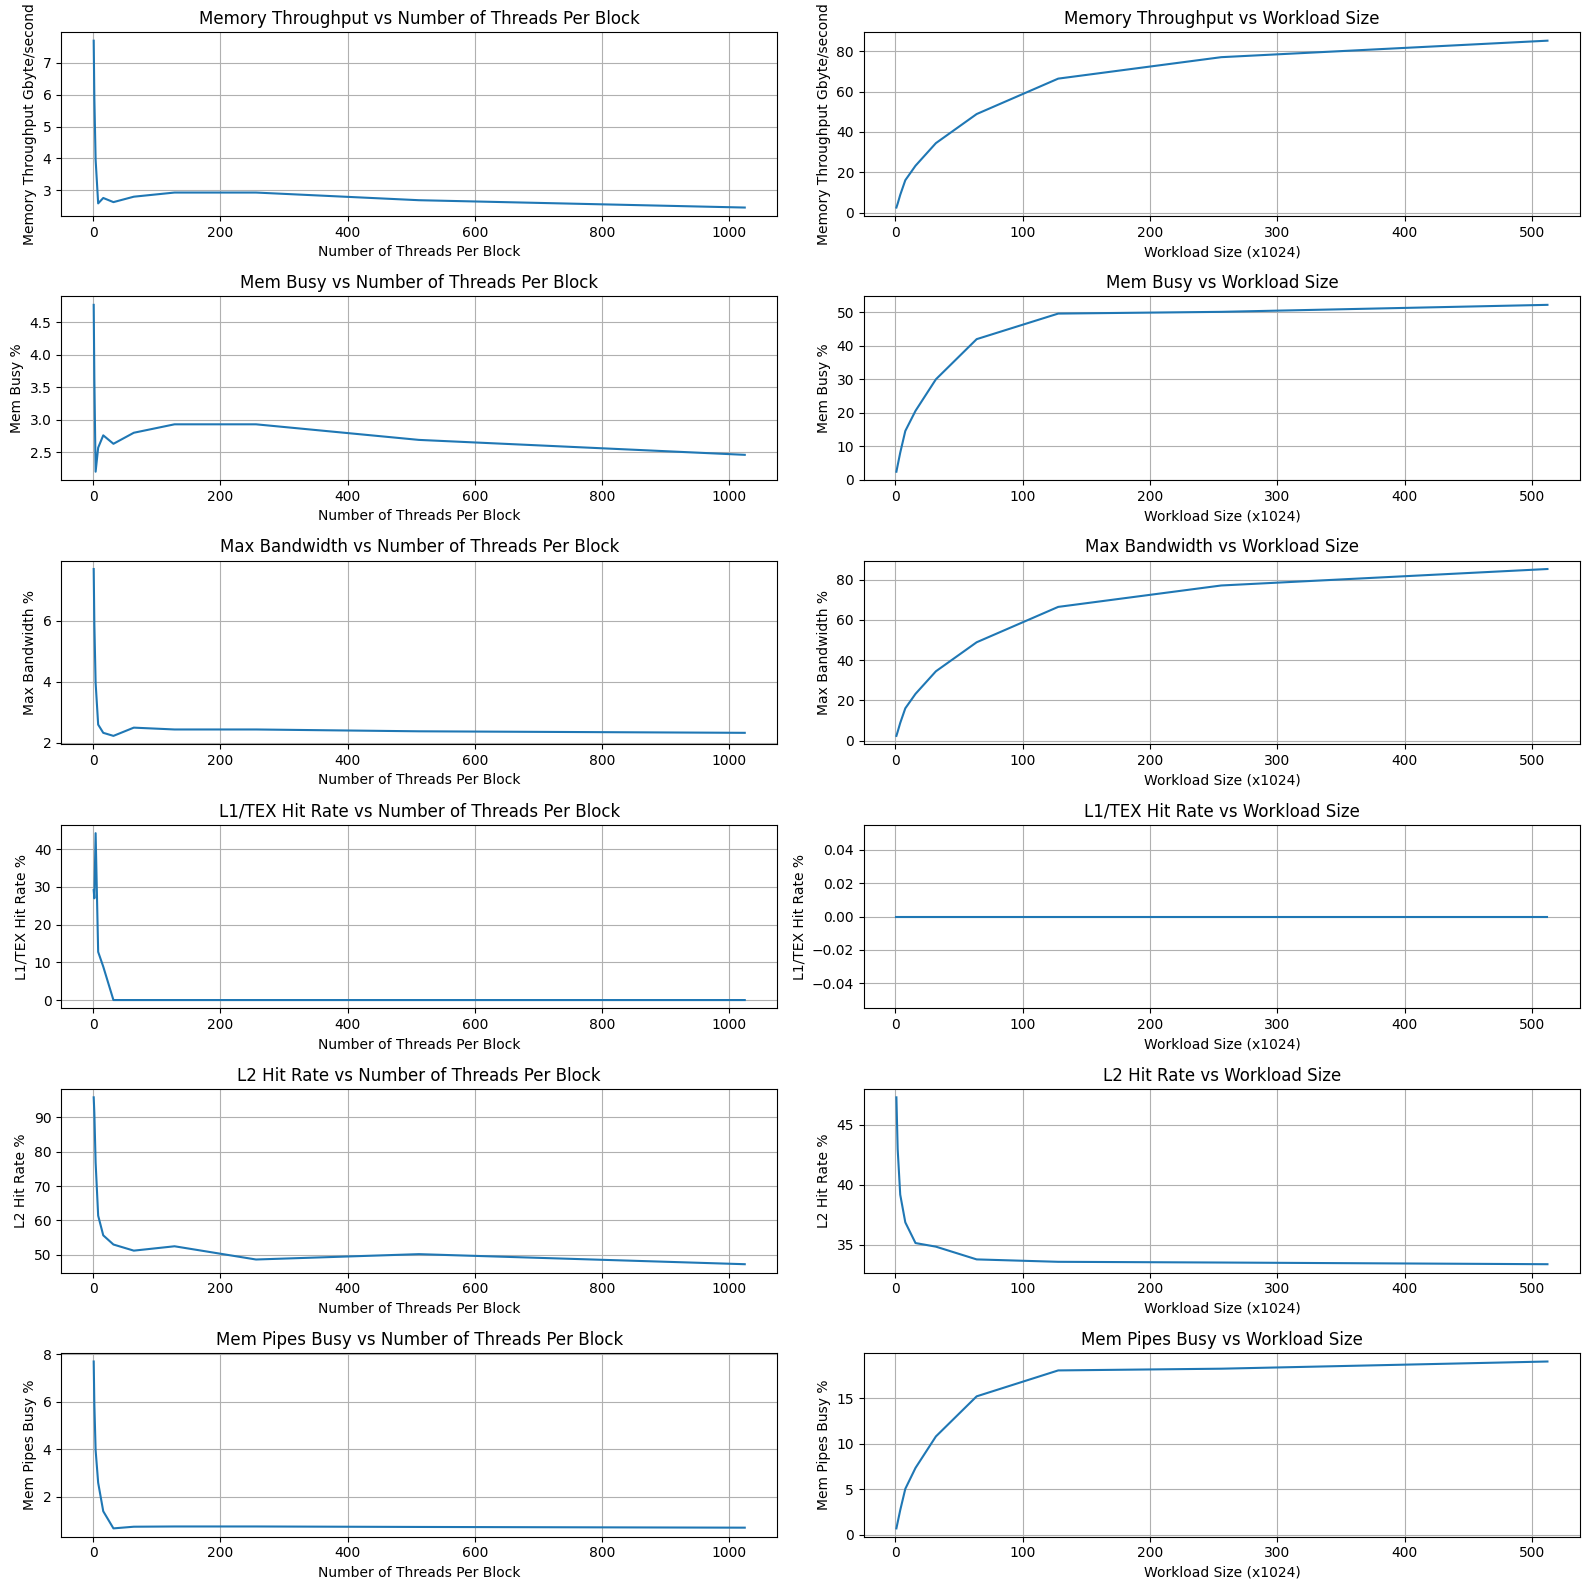

In [29]:
metrics = ['Memory Throughput', 'Mem Busy', 'Max Bandwidth', 'L1/TEX Hit Rate', 'L2 Hit Rate', 'Mem Pipes Busy']
metrics_u = ['Gbyte/second','%','%','%','%','%']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(6, 2, figsize=(16, 16),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

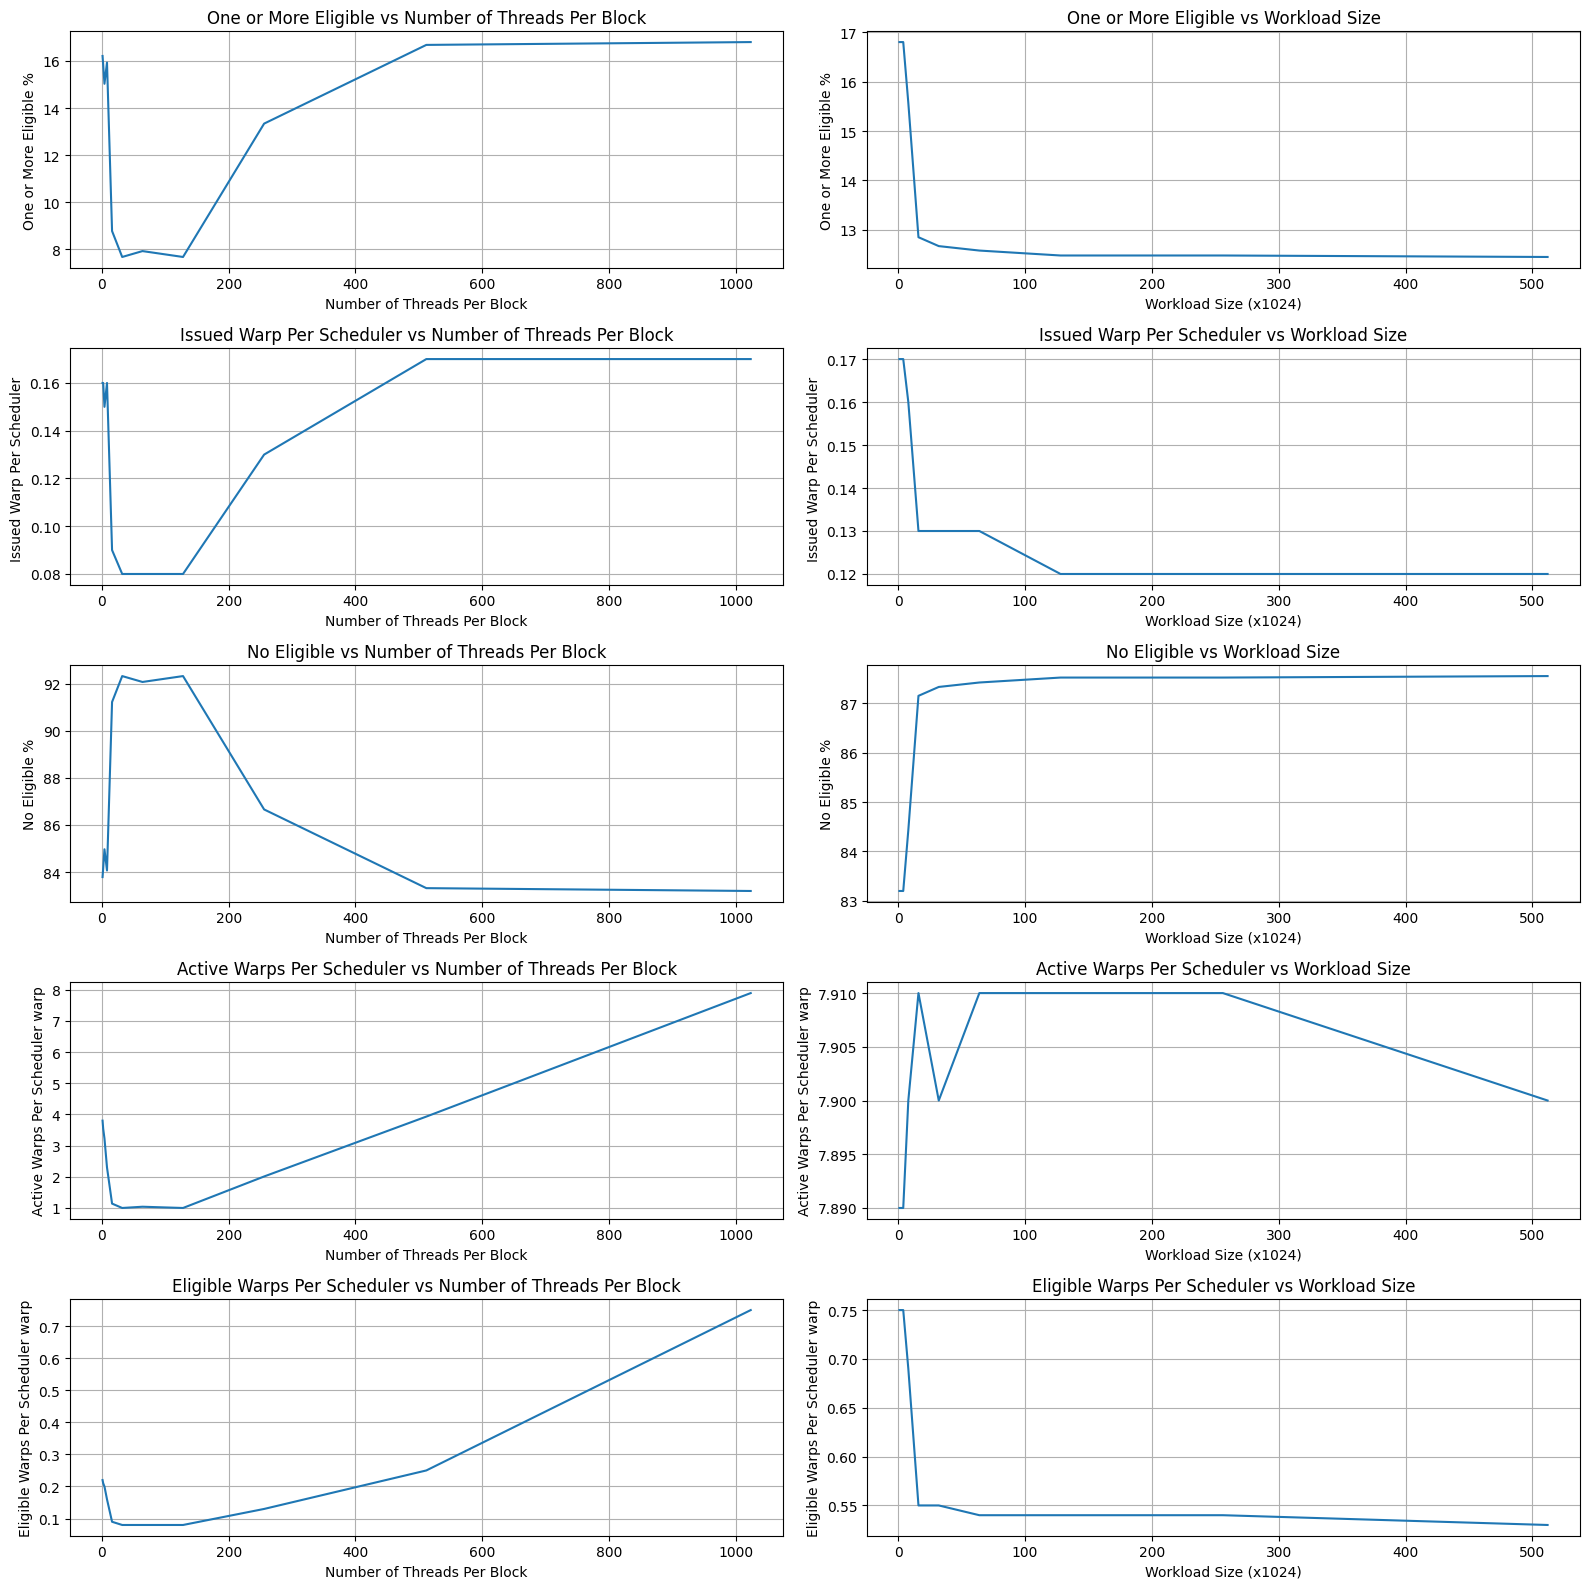

In [21]:
metrics = ['One or More Eligible', 'Issued Warp Per Scheduler', 'No Eligible', 'Active Warps Per Scheduler', 'Eligible Warps Per Scheduler']
metrics_u = ['%','','%','warp','warp']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(5, 2, figsize=(16, 16),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

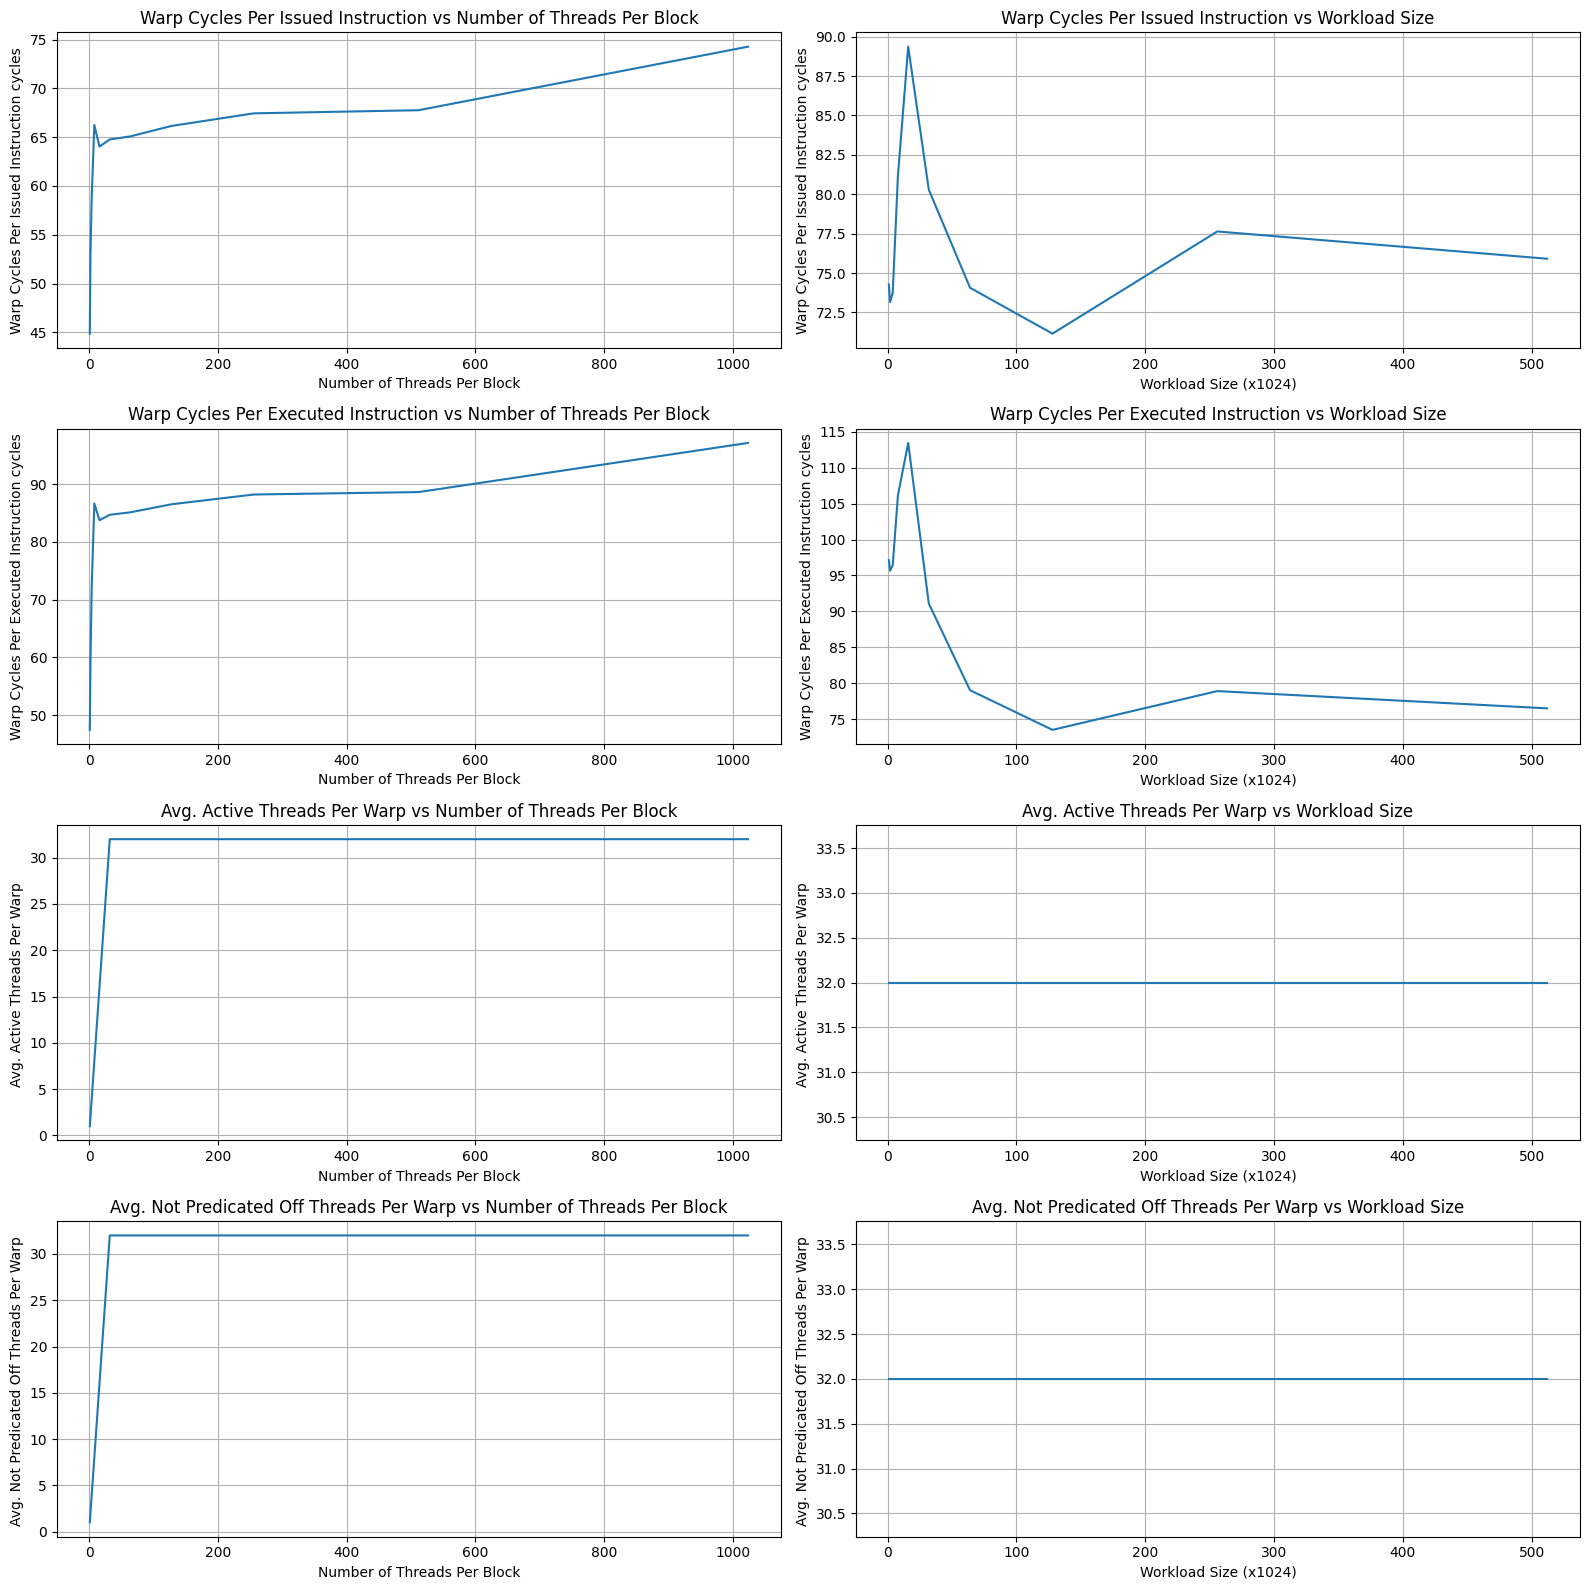

In [34]:
metrics = ['Warp Cycles Per Issued Instruction', 'Warp Cycles Per Executed Instruction', 'Avg. Active Threads Per Warp', 'Avg. Not Predicated Off Threads Per Warp']
metrics_u = ['cycles','cycles','','']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(4, 2, figsize=(16, 16),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

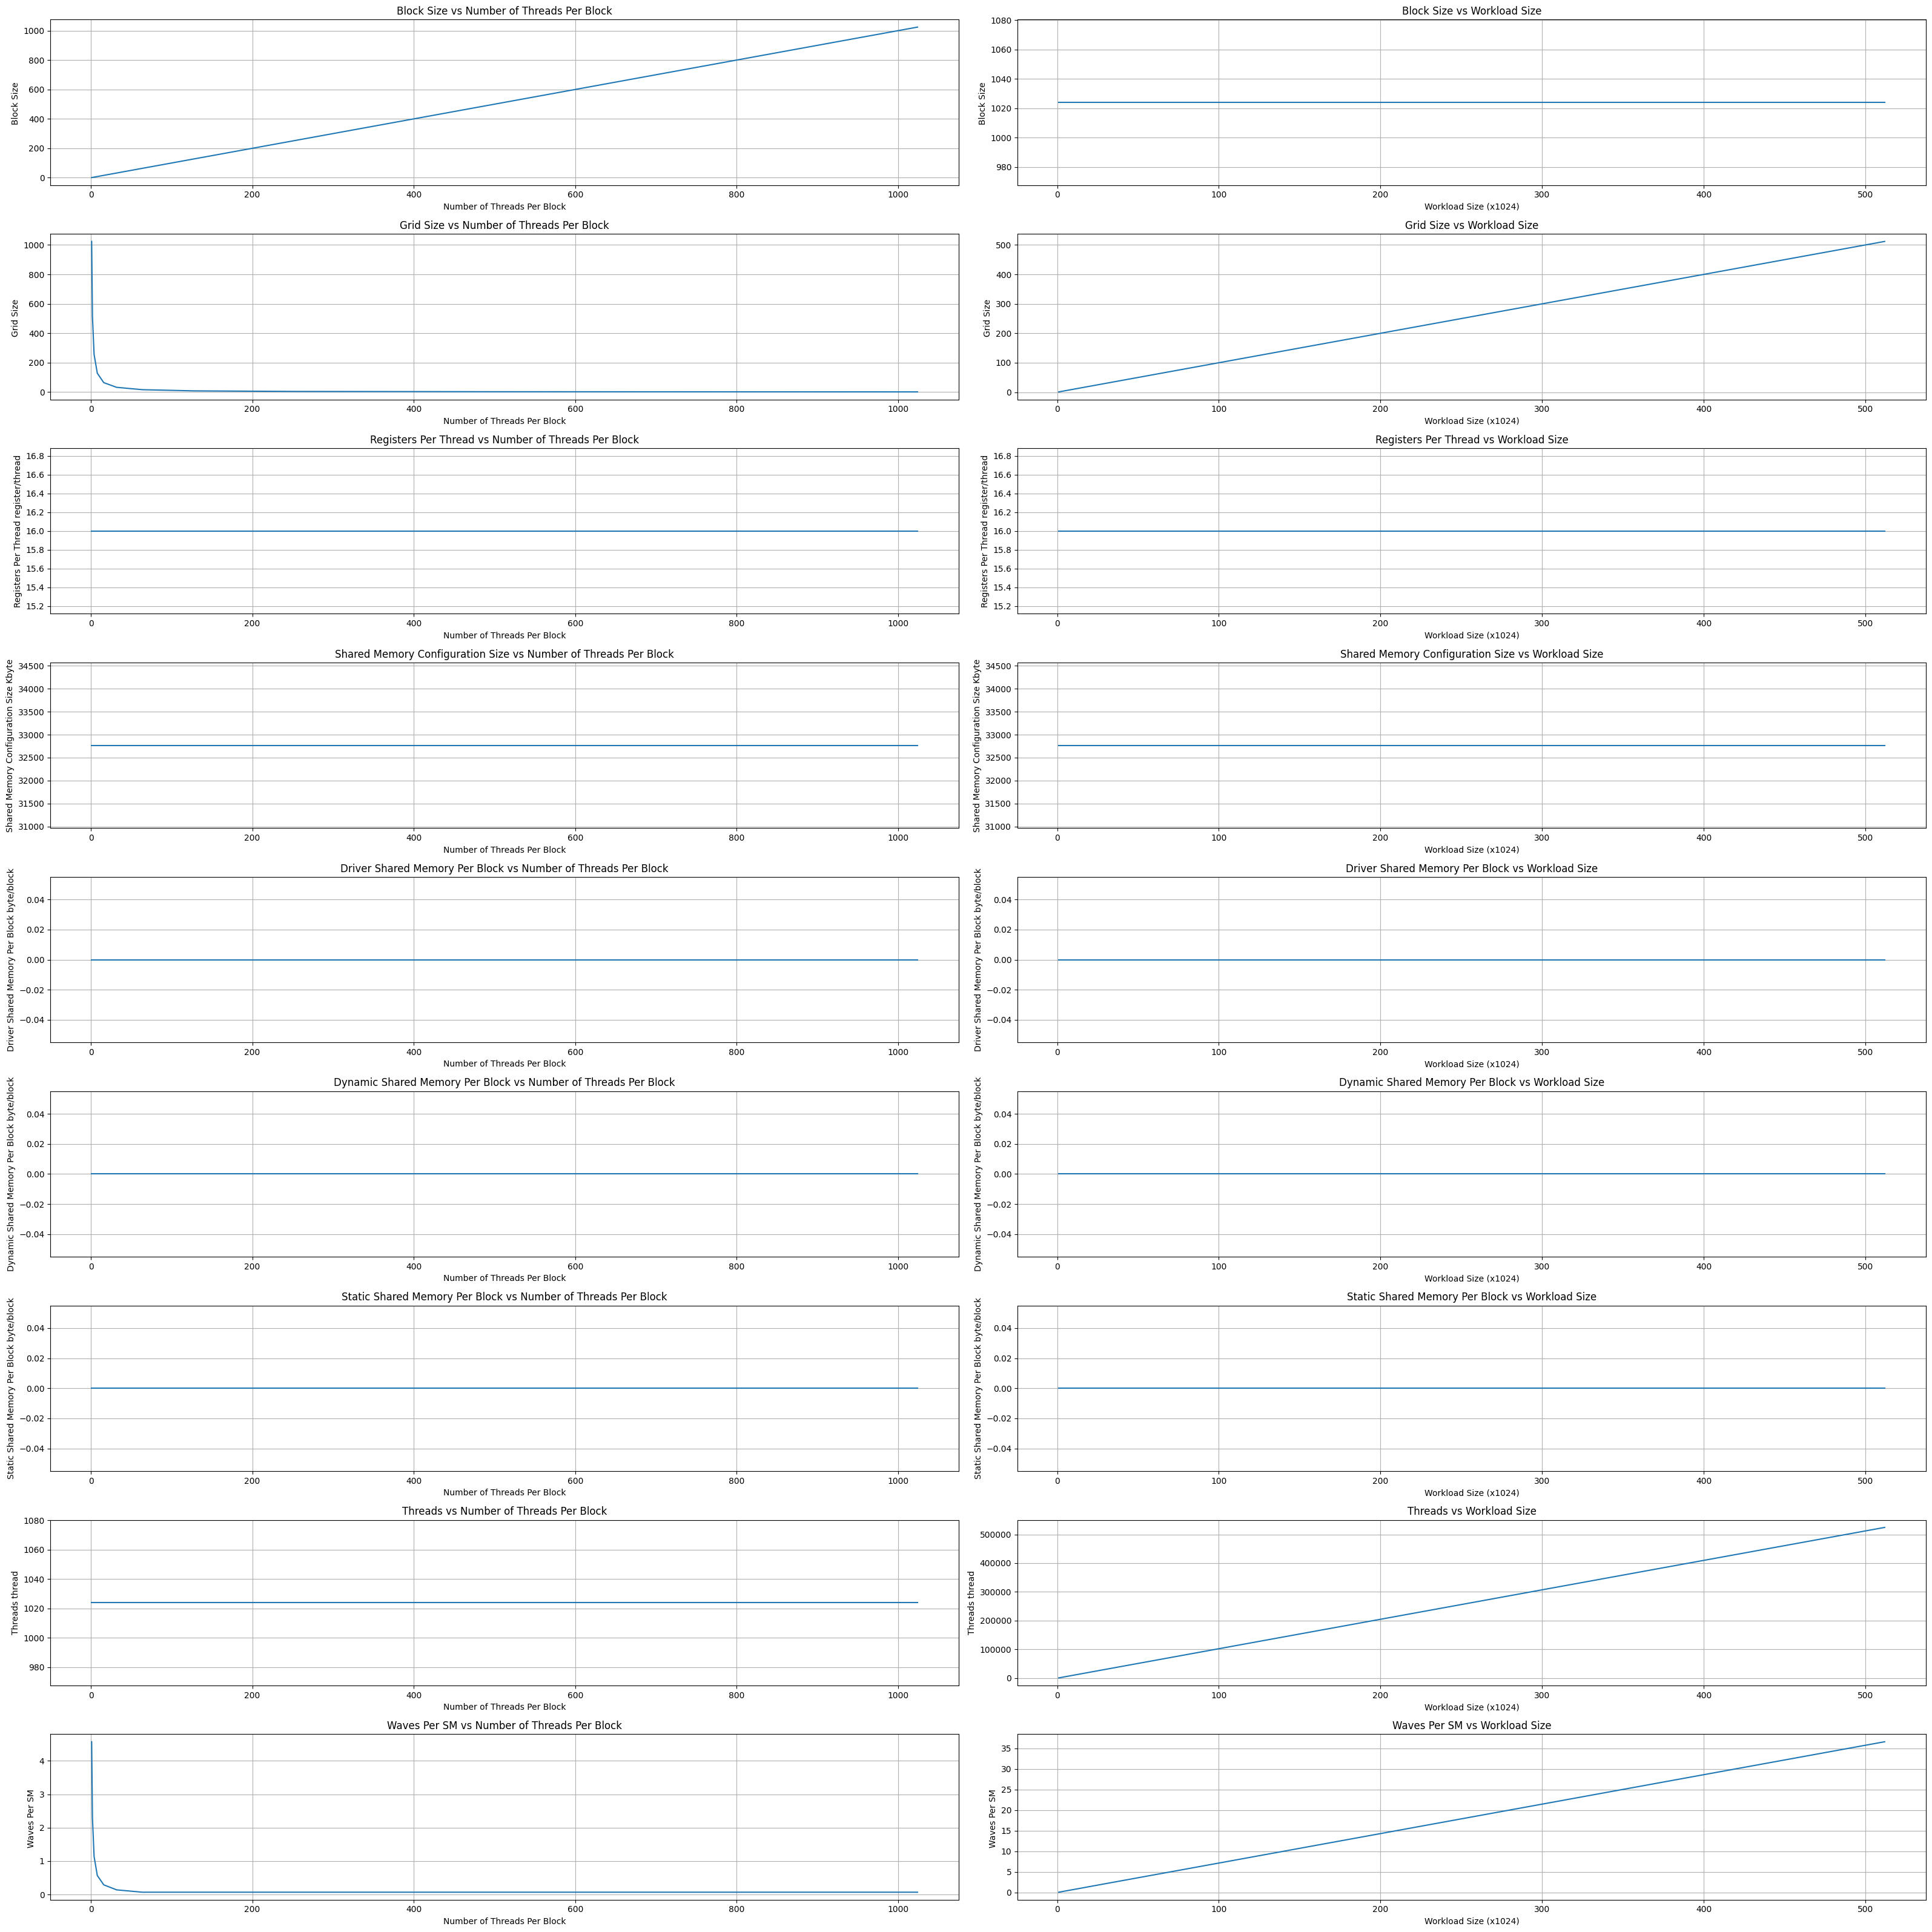

In [33]:
metrics = ['Block Size', 'Grid Size', 'Registers Per Thread', 'Shared Memory Configuration Size', 'Driver Shared Memory Per Block', 'Dynamic Shared Memory Per Block', 'Static Shared Memory Per Block','Threads','Waves Per SM']
metrics_u = ['','','register/thread','Kbyte','byte/block','byte/block','byte/block','thread', '']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(9, 2, figsize=(32, 32),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

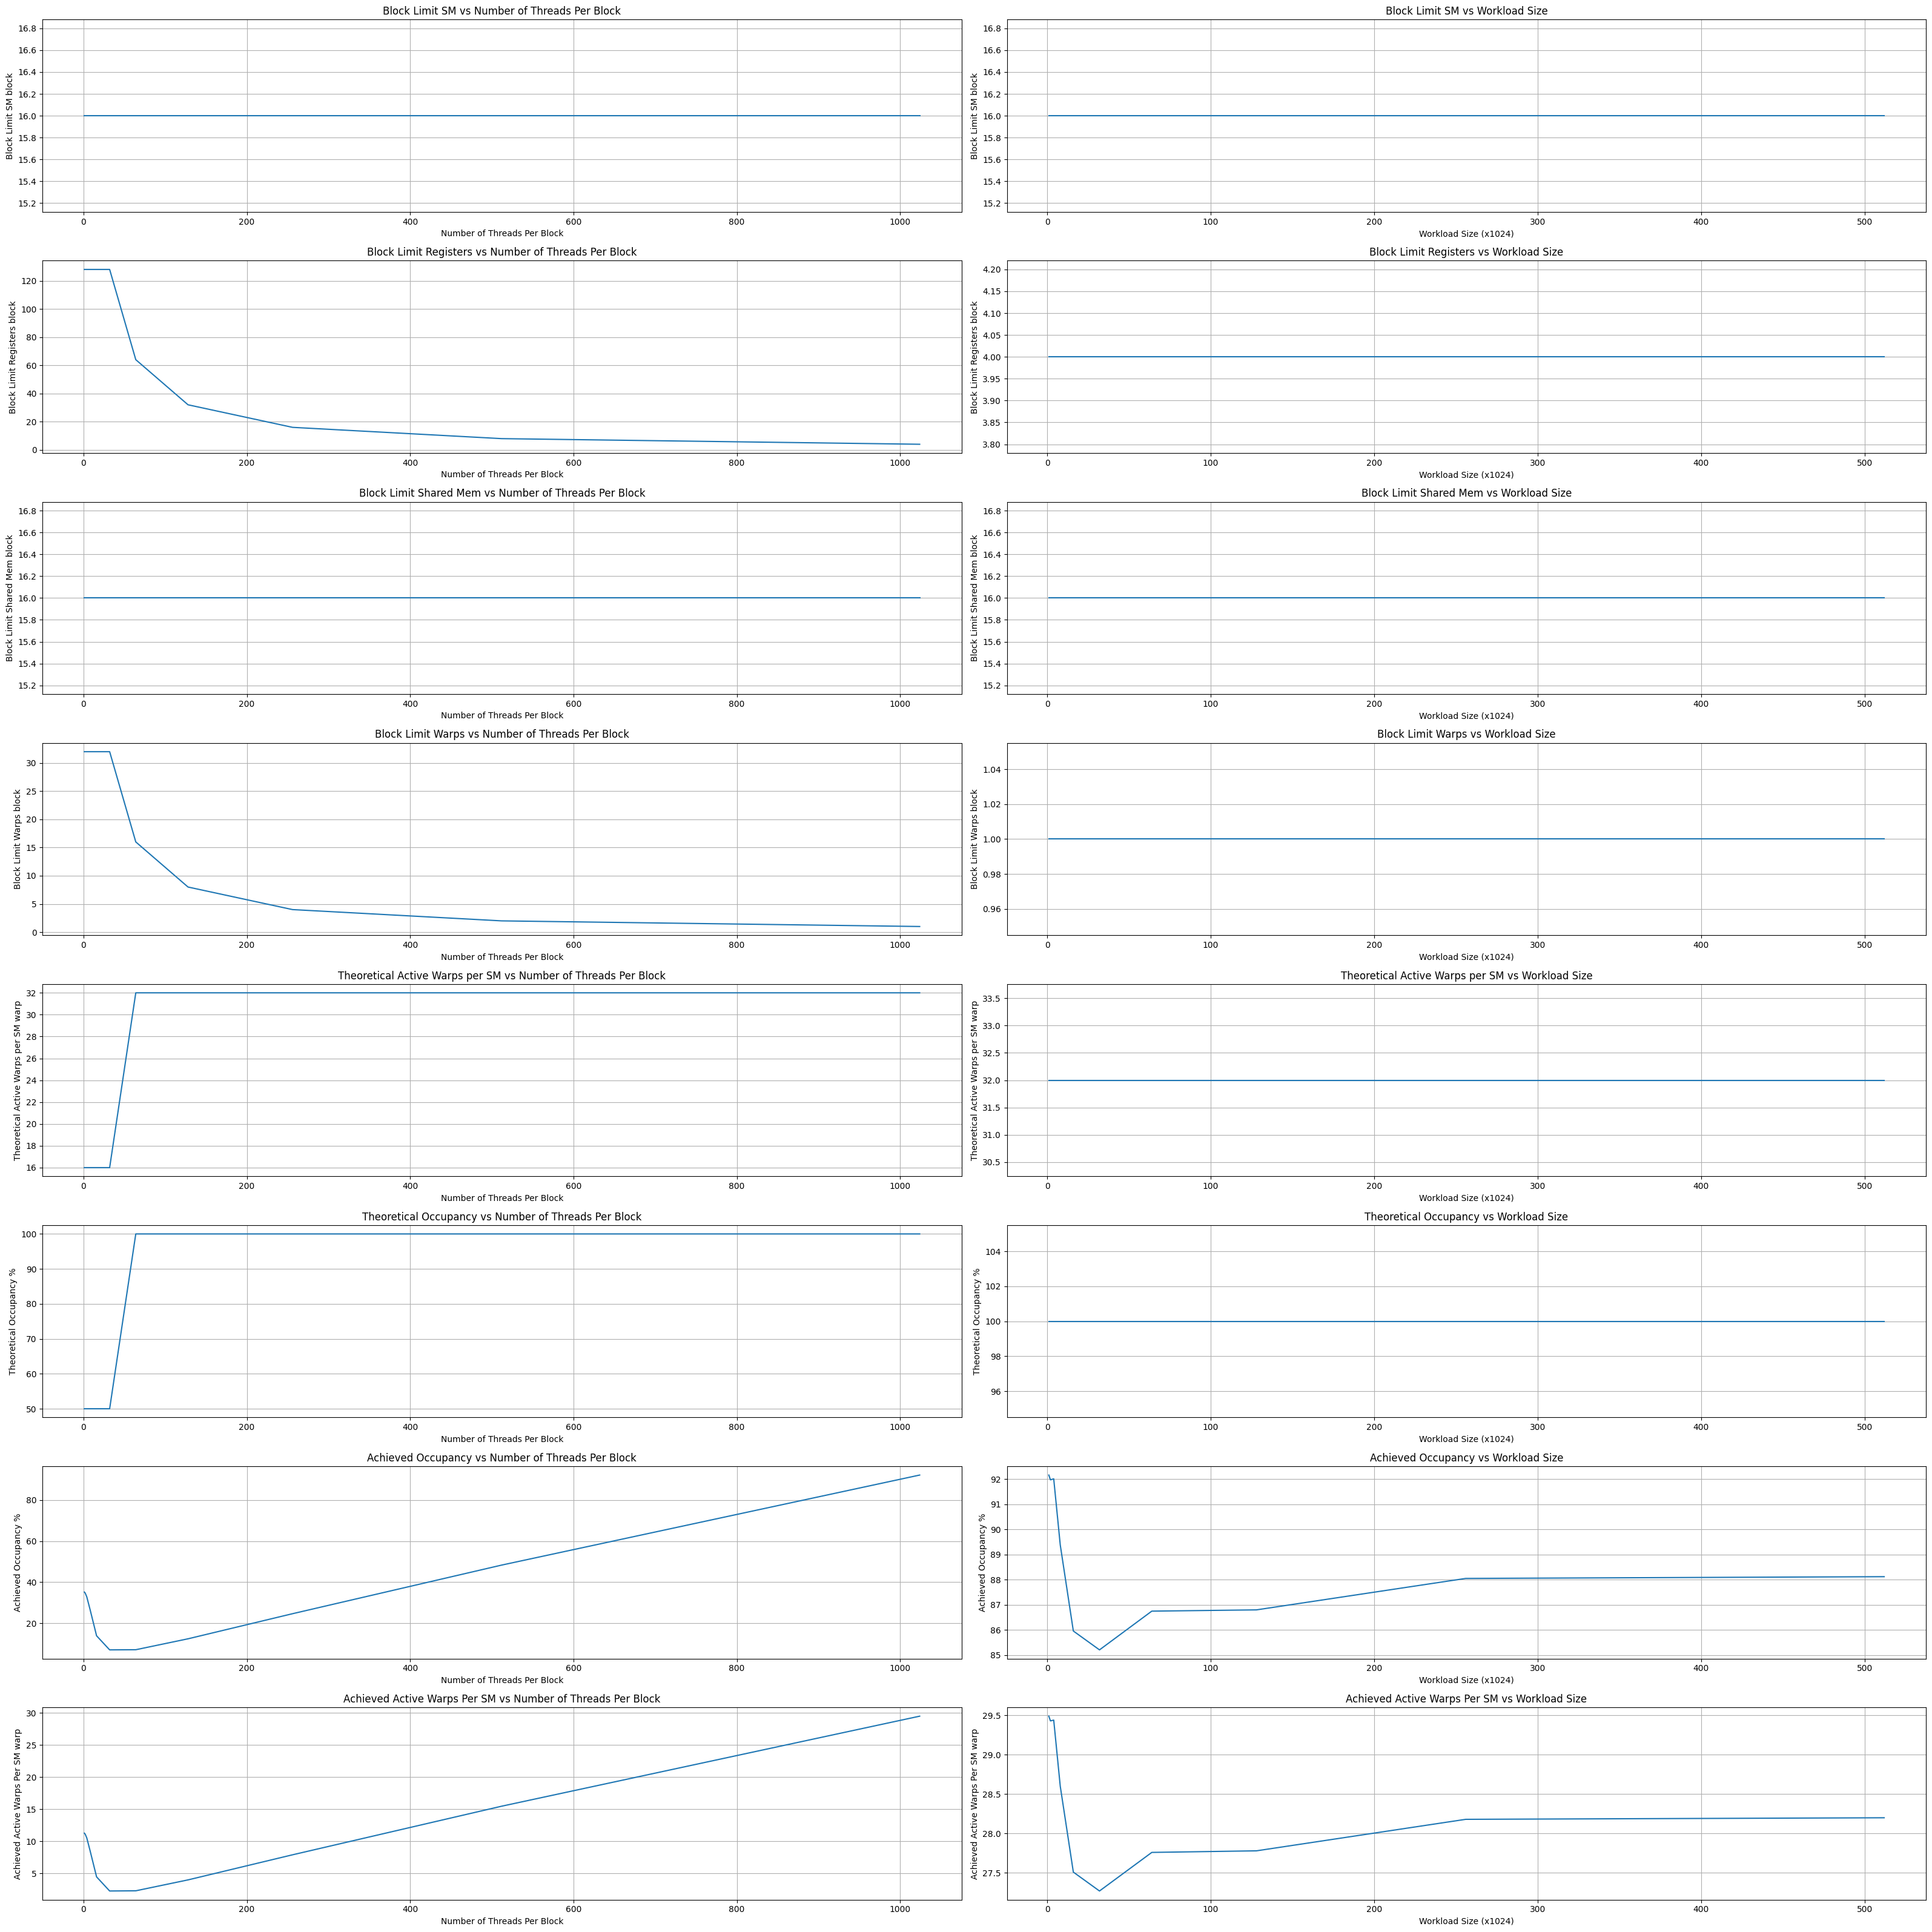

In [36]:
metrics = ['Block Limit SM', 'Block Limit Registers', 'Block Limit Shared Mem', 'Block Limit Warps', 'Theoretical Active Warps per SM', 'Theoretical Occupancy', 'Achieved Occupancy', 'Achieved Active Warps Per SM']
metrics_u = ['block','block','block','block','warp', '%', '%','warp']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(8, 2, figsize=(32, 32),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

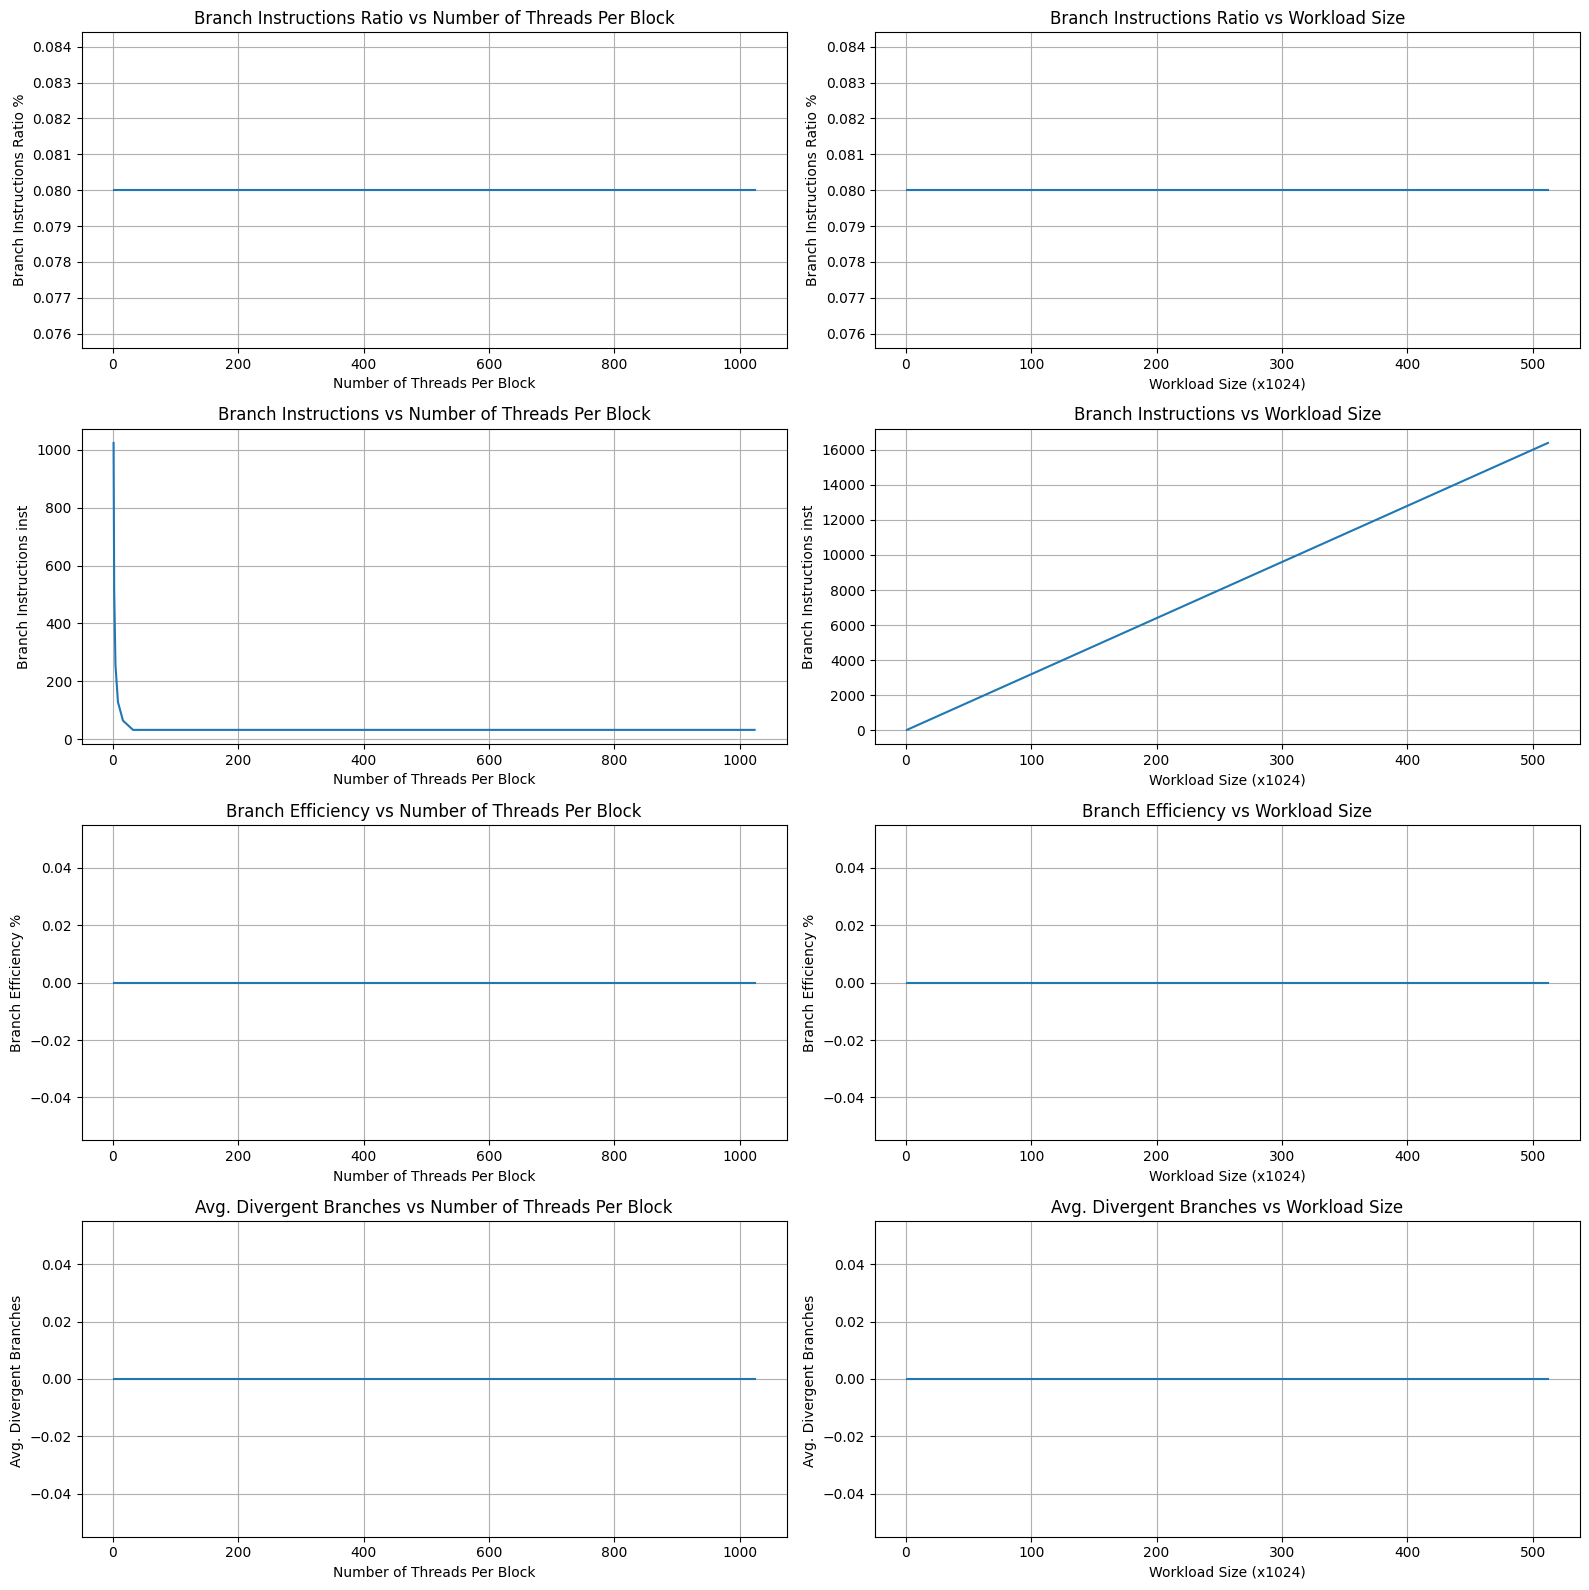

In [37]:
metrics = ['Branch Instructions Ratio', 'Branch Instructions', 'Branch Efficiency', 'Avg. Divergent Branches']
metrics_u = ['%','inst','%', '']
y = [i // 1024 for i in WORKLOAD_SMALL]
z = np.empty([len(metrics), len(WORKLOAD_SMALL), len(NUM_THREADS_PER_BLOCK)])
k = 'vectorAdd'
fig, axs = plt.subplots(4, 2, figsize=(16, 16),constrained_layout=False)
for u,m in enumerate(metrics):
    for i,w in enumerate(WORKLOAD_SMALL):
        for j,t in enumerate(NUM_THREADS_PER_BLOCK):
            z[u,i,j] = float(get_value(k,w,t,m,df).replace(',',''))

    axs[u,0].plot(NUM_THREADS_PER_BLOCK,z[u,0,:],label=metrics[u]);axs[u,0].set_title(f"{metrics[u]} vs Number of Threads Per Block");axs[u,0].grid()
    axs[u,0].set(xlabel='Number of Threads Per Block', ylabel=f"{metrics[u]} {metrics_u[u]}")
    axs[u,1].plot(y,z[u,:,-1],label=metrics[u]);axs[u,1].set_title(f"{metrics[u]} vs Workload Size");axs[u,1].grid()
    axs[u,1].set(xlabel='Workload Size (x1024)', ylabel=f"{metrics[u]} {metrics_u[u]}")

plt.tight_layout()
plt.show()

# DCGM Metrics

In [ ]:
# import subprocess

# ## Init DCGM Agent
# manualOpMode = True
# embeddedHostengine = True
# main = DCGM_AGENT()
# main.init(manualOpMode, embeddedHostengine)

# ## Init Program
# k = "vsctorAdd"
# w = 1024
# t = 1024
# cmd_args = [f"{PATH_TO_KERNELS}/{k}", "-nN={w}","-nT={t}"]




